### import

In [74]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch

# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

In [75]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.5.1
Transformers version: 4.47.0
Accelerate version: 0.26.0


### voice to text


In [76]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [77]:
from typing import Union  # 添加 Union 导入

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [78]:
%matplotlib inline
# from IPython.display import display, Image
class HybridEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # 初始化模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 获取CLIP模型的输出维度
        with torch.no_grad():
            dummy_image = torch.zeros((1, 3, 224, 224))
            image_features = self.clip_model.get_image_features(dummy_image)
            self.image_dimension = image_features.shape[1]  # 应该是 512

        # 设置 Chroma
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 使用 SentenceTransformer embedding function
        sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name='all-mpnet-base-v2',
            device="cpu"
        )
        
        try:
            # 删除现有的集合
            collections_to_delete = ["questions", "answers", "image_documents"]
            for collection_name in collections_to_delete:
                try:
                    self.chroma_client.delete_collection(collection_name)
                    logger.info(f"Deleted collection: {collection_name}")
                except Exception as e:
                    # pass
                    logger.info(f"Collection {collection_name} does not exist or could not be deleted: {str(e)}")
            
            # 创建新的集合
            # 创建新的集合，指定维度
            sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name='all-mpnet-base-v2'
            )

            self.question_collection = self.chroma_client.create_collection(
                name="questions",
                embedding_function=sentence_transformer_ef
            )
            
            self.answer_collection = self.chroma_client.create_collection(
                name="answers",
                embedding_function=sentence_transformer_ef
            )
            
            self.image_collection = self.chroma_client.create_collection(
                name="image_documents",
                metadata={"dimension": self.image_dimension}
            )
            logger.info(f"Created collections with image dimension: {self.image_dimension}")

            
        except Exception as e:
            logger.error(f"Error initializing collections: {str(e)}")
            raise

    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_qa_id": f"q_{i}" if i < len(questions) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image(self, image_path: str) -> Optional[np.ndarray]:
            """處理圖片並生成 embedding"""
            try:
                logger.info(f"Processing image: {image_path}")
                processed_path = self.image_processor.process_and_save(
                    image_path=image_path,
                    target_size=self.image_size
                )
                
                if processed_path is None:
                    logger.error(f"Failed to process image: {image_path}")
                    return None
                    
                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                image_features = self.clip_model.get_image_features(**inputs)
                
                logger.info(f"Successfully generated embedding for image: {image_path}")
                return image_features.detach().numpy()[0]
                
            except Exception as e:
                logger.error(f"Error processing image {image_path}: {str(e)}")
                return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                logger.info(f"Adding {len(texts)} text documents")
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info("Successfully added text documents")
            
            # 處理並添加圖片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    logger.info(f"Processing image {i+1}/{len(images)}: {img_path}")
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info("Successfully added images to collection")
                else:
                    logger.warning("No valid images to add to collection")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}", exc_info=True)
            raise
    
    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None
        
    def search(self, query: str, k: int = 3) -> Dict:
        """整合社群和专业知识的搜索方法"""
        try:
            logger.info("Starting search operation...")
            
            # 1. 搜索社群问答
            social_results = self.question_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 2. 搜索专业文献
            professional_results = self.answer_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 3. 整合结果并标记来源
            combined_results = {
                "social": {
                    "questions": social_results["documents"][0] if social_results["documents"] else [],
                    "answers": social_results["answers"] if "answers" in social_results else [],
                    "metadata": social_results["metadatas"][0] if social_results["metadatas"] else [],
                    "relevance": social_results["distances"][0] if social_results["distances"] else []
                },
                "professional": {
                    "content": professional_results["documents"][0] if professional_results["documents"] else [],
                    "metadata": professional_results["metadatas"][0] if professional_results["metadatas"] else [],
                    "relevance": professional_results["distances"][0] if professional_results["distances"] else []
                }
            }
            
            # 4. 搜索相关图片
            image_results = self._search_images(query, k)
            combined_results["images"] = image_results

            return combined_results
                
        except Exception as e:
            logger.error(f"Search error: {str(e)}")
            return {
                "social": {"questions": [], "answers": [], "metadata": [], "relevance": []},
                "professional": {"content": [], "metadata": [], "relevance": []},
                "images": {"metadata": [], "paths": [], "relevance": []}
            }
    def _search_images(self, query: str, k: int = 3) -> Dict:
        """Search for relevant images"""
        try:
            # Use the image collection to search for similar images
            image_results = self.image_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            return {
                "metadata": image_results.get("metadatas", []),
                "paths": image_results.get("ids", []),
                "relevance": image_results.get("distances", [])
            }
        except Exception as e:
            logger.error(f"Error searching images: {str(e)}")
            return {
                "metadata": [],
                "paths": [],
                "relevance": []
            }

### 資料處理模組

In [79]:
class DataProcessor:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'link': current_link,
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses)
                        }
                    }
                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最后一个问答对
        if current_post is not None:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'link': current_link,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses)
                }
            }
            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    def is_title_line(line: str) -> bool:
        """检查是否是标题行"""
        # 清理空白
        line = line.strip()
        if not line:
            return False
            
        # 标题的特征
        is_likely_title = (
            # 全大写或首字母大写
            line.isupper() or line.istitle() or
            # 常见的章节名称
            any(keyword in line.lower() for keyword in [
                'abstract', 'introduction', 'method', 'result', 
                'discussion', 'conclusion', 'reference'
            ]) and
            # 长度适中
            5 < len(line) < 100
        )
        
        return is_likely_title
    
    def clean_title(title: str) -> str:
        """清理并标准化标题文本"""
        # 移除数字和特殊字符
        title = ''.join(c for c in title if c.isalpha() or c.isspace())
        # 清理空白
        title = ' '.join(title.split())
        return title
    
    def process_pdf(self, pdf_path: str) -> List[Dict]:
        """处理单个 PDF 文件"""
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    # 处理每个段落
                    for para in paragraphs:
                        qa_pair = {
                            'question': para[:50] + "...",  # 暂时用段落开头作为问题标识
                            'answers': [para],
                            'metadata': {
                                'type': 'professional',
                                'source_file': pdf_name,  # 添加文件名
                                'page': str(page_num + 1),
                                'content_length': str(len(para))
                            }
                        }
                        professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """处理所有数据：社群数据和多个 PDF"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path("image") / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并所有数据
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 准备数据存储
            questions = []
            answers = []
            question_metadatas = []
            answer_metadatas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                questions.append(qa_pair['question'])
                question_metadatas.append(qa_pair['metadata'])
                
                # 添加该问题的所有回答
                answers.extend(qa_pair['answers'])
                # 为每个回答创建对应的元数据
                for _ in qa_pair['answers']:
                    answer_metadata = qa_pair['metadata'].copy()
                    answer_metadata['parent_question'] = qa_pair['question']
                    answer_metadatas.append(answer_metadata)
            
            # 5. 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 6. 添加到 Chroma
            self.embedding_processor.add_qa_pairs(
                questions=questions,
                answers=answers,
                question_metadatas=question_metadatas,
                answer_metadatas=answer_metadatas,
                images=valid_images
            )
            
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise



### QA系統模組

##### prompt

In [80]:
role = """
You are a professional veterinarian specializing in:

Diagnosis and care of Canine Cognitive Dysfunction Syndrome (CCD)
Pet behavior problem diagnosis and improvement suggestions
"""

In [81]:
task = """
Please handle user questions according to the following steps:
Please refer to the references provided below to answer
Step 1: Determine if images are needed in the system response
Based on the question content:

Environment-related: Space planning, facility placement, equipment usage, etc.
Behavior-related: Posture, movement, physical appearance, etc.
Care-related: Wheelchairs, activity areas, equipment usage, etc.
Product recommendations: Medications, assistive devices

Step 2: Provide recommendations
Text response:

Provide professional advice based on textual information
Explain relevant symptoms and precautions
If there are relevant images, naturally incorporate image descriptions into the content
For example:
"Consider using MCT oil (as shown in Figure 1) for nutritional supplementation"
"Veterinarians may prescribe cognitive support medications (such as CogniCaps shown in Figure 2)"

If images are needed:

Find appropriate photos from reference materials
Naturally embed image descriptions within relevant recommendations rather than placing them all at the end
Explain how the images relate to the recommendations (e.g., this is the recommended nutritional supplement, this is a commonly prescribed medication, etc.)
If images are needed but not available in reference materials, proceed without images

Step 3: Response format

Symptom/problem analysis
Professional advice explanation
Recommendations based on community-collected data
Necessary medical reminders
If reference materials are used, mark the source at the end of the response, e.g., [xxx.pdf] or [Link] for community post references

Please respond with empathy and a professional tone.
"""

##### code

In [82]:
class QASystem:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def generate_response(self, query: str) -> Tuple[str, List[str]]:
        try:
            search_results = self.embedding_processor.search(query)
            context = self.format_context(search_results)
            
            message = {
                'role': 'user',
                'content': f"""{role}

                    {task}

                    用户问题: {query}

                    参考资料:
                    {context}
                    """
            }

            # 处理图片（如果有）
            image_paths = []
            if (search_results.get("social") and 
                search_results["social"].get("metadata")):
                for meta in search_results["social"]["metadata"]:
                    if meta.get("images"):
                        for img in meta["images"].split(","):
                            img_path = self.embedding_processor.image_dir / img
                            if img_path.exists():
                                image_paths.append(str(img_path.resolve()))
                                # Ollama 只支持一张图片，所以只取第一张
                                message['images'] = [image_paths[0]]
                                break
                        if message.get('images'):
                            break

            # 生成响应
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )

            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            return f"非常抱歉，在处理您的问题时遇到了技术问题。", []

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""
            
            # 添加社群问答内容
            if search_results.get("social"):
                context += "\n[社群讨论]\n"
                for q, meta in zip(
                    search_results["social"]["questions"],
                    search_results["social"]["metadata"]
                ):
                    context += f"问题: {q}\n"
                    if "answer_count" in meta:
                        context += f"回答数: {meta['answer_count']}\n\n"

            # 添加专业内容
            if search_results.get("professional"):
                context += "\n[专业参考]\n"
                for content in search_results["professional"]["content"]:
                    context += f"{content}\n\n"
            
            return context if context else "未找到相关信息"
                
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"
 


    def display_response(self, query: str):
            """Display response with text and images"""
            try:
                logger.info("Starting to generate response...")
                response_text, image_paths = self.generate_response(query)
                
                print("Question:", query)
                print("\nSystem Response:")
                print(response_text)
                print("\n" + "-"*50 + "\n")

                if image_paths:
                    print("\nRelated Image:")
                    img_path = image_paths[0]  # We now only have one image
                    try:
                        img = PILImage.open(img_path)
                        display(IPyImage(filename=img_path))
                    except Exception as e:
                        logger.error(f"Error displaying image {img_path}: {str(e)}")
                else:
                    logger.info("No images to display")
                    
            except Exception as e:
                logger.error(f"Error in display_response: {str(e)}", exc_info=True)   

### 系統初始化和資料處理

In [84]:
# 初始化 embedding processor
embedding_processor = HybridEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

pdf_paths = [
    "RAG_data/01.pdf",
    "RAG_data/02.pdf",
    "RAG_data/03.pdf"
]

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response.csv",
    pdf_paths=pdf_paths
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
python(22683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:__main__:Created collections with image dimension: 512
INFO:__main__:Processing CSV: post_response.csv
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post
INFO:__m

### 系統測試

In [85]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 聽說MCT oil對失智狗狗有幫助，但我家狗有肝問題，這樣吃合適嗎？

System Response:
I understand your concern about using MCT oil for your dog with liver problems. While MCT oil can be beneficial for dogs with cognitive dysfunction, it's essential to consult with a veterinarian before adding any new supplements to their diet.

MCT oil is derived from coconut or palm kernel oil and contains medium-chain triglycerides (MCTs), which are easily absorbed by the body and provide energy. Some studies suggest that MCT oil may help improve cognitive function in dogs, but more research is needed to confirm these findings.

However, as you mentioned, your dog has liver problems, and it's crucial to ensure that any supplement they take won't exacerbate their condition. I recommend consulting with a veterinarian who can assess your dog's individual needs and provide personalized advice on whether MCT oil or other supplements would be suitable for them.

In addition to seeking professional guidance, you may also want to

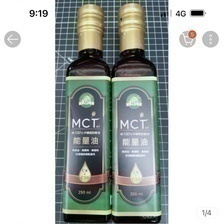

In [87]:
# 測試查詢
test_queries = ["聽說MCT oil對失智狗狗有幫助，但我家狗有肝問題，這樣吃合適嗎？"]

for query in test_queries:
    qa_system.display_response(query)


 test


In [ ]:
# 查看搜索结果
search_results = embedding_processor.search(test_queries)
print("\n搜索到的问题数:", len(search_results['social']['questions']))
print("\n搜索到的专业内容数:", len(search_results['professional']['content']))
print("\n相关图片数:", len(search_results['images']['metadatas'][0]) if search_results['images']['metadatas'] else 0)

INFO:__main__:Starting search operation...
ERROR:__main__:Search error: Expected document to be a str, got ['我家狗晚上會繞圈圈，不知道是不是算失智症狀？我想提前準備好，有適合她活動的佈置嗎？'] in query.



搜索到的问题数: 0

搜索到的专业内容数: 0


KeyError: 'metadatas'

In [ ]:
print(f"Question Collection 数量: {qa_system.embedding_processor.question_collection.count()}")
print(f"Answer Collection 数量: {qa_system.embedding_processor.answer_collection.count()}")
print(f"Image Collection 数量: {qa_system.embedding_processor.image_collection.count()}")

InvalidCollectionException: Collection f2177224-8981-405f-9af6-22c737620281 does not exist.